In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
class PerformanceAnalyzer:
    def __init__(self, directory):
        """
        Initializes the PerformanceAnalyzer with a list of file names.

        :param files: List of file paths to process.
        """
        self.original_times = []
        self.avx_times = []
        self.scores = []
        self.text_lengths = []
        self.pattern_lengths = []
        self.improvements = []
        self.speedups = []

        self.files = ["150.txt", "300.txt", "500.txt", "750.txt", "1000.txt"]
        self.files = [os.path.join(directory, file) for file in self.files]

    def extract_data(self):
        """Reads all files and extracts relevant data using regex."""
        for file_name in self.files:
            with open(file_name, "r") as file:
                data = file.read()

            # Extract execution times, scores, text lengths, and pattern lengths
            self.original_times += list(map(float, re.findall(r"Execution Time \(Original\)\s*:\s*([\d.]+)", data)))
            self.avx_times += list(map(float, re.findall(r"Execution Time \(AVX\)\s*:\s*([\d.]+)", data)))
            self.scores += list(map(int, re.findall(r"Score:\s*([-]?\d+)", data)))
            self.text_lengths += list(map(int, re.findall(r"Text\s*\[Sequence \d+\] \(Length\s*(\d+)\)", data)))
            self.pattern_lengths += list(map(int, re.findall(r"Pattern\s*\[Sequence \d+\] \(Length\s*(\d+)\)", data)))

    def compute_metrics(self):
        """Computes speedup and improvement percentage."""
        if not self.original_times or not self.avx_times:
            raise ValueError("No data available. Run extract_data() first.")

        self.speedups = [o / a if a != 0 else float("inf") for o, a in zip(self.original_times, self.avx_times)]
        self.improvements = [(o - a) / o * 100 if o != 0 else 0 for o, a in zip(self.original_times, self.avx_times)]

    def print_metrics(self):
        # Ensure lengths match before plotting
        print(f"Original Times Length: {len(self.original_times)}")
        print(f"AVX Times Length: {len(self.avx_times)}")
        print(f"Scores Length: {len(self.scores)}")
        print(f"Text Lengths Length: {len(self.text_lengths)}")
        print(f"Pattern Lengths Length: {len(self.pattern_lengths)}")
        print(f"Improvements Length: {len(self.improvements)}")

    def plot_performance_improvement(self):
        plt.figure(figsize=(10, 15))
        plt.subplot(3, 1, 1)
        plt.bar(self.pattern_lengths, self.improvements, color='skyblue')
        plt.xlabel("Pattern Length")
        plt.ylabel("Performance Improvement (%)")
        plt.title("Performance Improvement of AVX over Original Execution (Pattern Length)")
        plt.xticks(self.pattern_lengths)
        plt.grid(axis='y', linestyle="--", alpha=0.7)

        plt.subplot(3, 1, 2)
        plt.scatter(self.text_lengths, self.improvements, color='lightcoral', alpha=0.7)
        plt.xlabel("Text Length")
        plt.ylabel("Performance Improvement (%)")
        plt.title("Performance Improvement of AVX over Original Execution (Text Length)")
        plt.grid(axis='y', linestyle="--", alpha=0.7)

        plt.subplot(3, 1, 3)
        plt.scatter(self.scores, self.improvements, color='lightgreen', alpha=0.7)
        plt.xlabel("Score")
        plt.ylabel("Performance Improvement (%)")
        plt.title("Performance Improvement of AVX over Original Execution (Score)")
        plt.grid(axis='y', linestyle="--", alpha=0.7)

        plt.tight_layout()
        plt.show()

    def plot_execution_time_comparison(self):
        fig, axes = plt.subplots(3, 1, figsize=(10, 15))
        fig.suptitle("Execution Time Comparison", fontsize=16)

        axes[0].scatter(self.scores, self.original_times, color='blue', alpha=0.7, label="Original")
        axes[0].scatter(self.scores, self.avx_times, color='red', alpha=0.7, label="AVX")
        coeffs_original = np.polyfit(self.scores, self.original_times, 1)
        poly_original = np.poly1d(coeffs_original)
        axes[0].plot(self.scores, poly_original(self.scores), color='blue', linestyle='--', label="Original Fit Line")
        coeffs_avx = np.polyfit(self.scores, self.avx_times, 1)
        poly_avx = np.poly1d(coeffs_avx)
        axes[0].plot(self.scores, poly_avx(self.scores), color='red', linestyle='--', label="AVX Fit Line")
        axes[0].set_xlabel("Score")
        axes[0].set_ylabel("Execution Time [ms]")
        axes[0].set_title("Execution Time vs. Score")
        axes[0].grid(True, linestyle="--", alpha=0.7)
        axes[0].legend()

        axes[1].scatter(self.text_lengths, self.original_times, color='blue', alpha=0.7, label="Original")
        axes[1].scatter(self.text_lengths, self.avx_times, color='red', alpha=0.7, label="AVX")
        axes[1].set_xlabel("Text Length")
        axes[1].set_ylabel("Execution Time [ms]")
        axes[1].set_title("Execution Time vs. Text Length")
        axes[1].grid(True, linestyle="--", alpha=0.7)
        axes[1].legend()

        pattern_set = sorted(set(self.pattern_lengths))
        axes[2].boxplot([np.array(self.original_times)[np.array(self.pattern_lengths) == p] for p in pattern_set], 
                        positions=[p - 30 for p in pattern_set], widths=50, patch_artist=True,
                        boxprops=dict(facecolor="blue", color="blue"),
                        whiskerprops=dict(color="blue"),
                        capprops=dict(color="blue"),
                        flierprops=dict(markerfacecolor="blue", marker="o"))

        axes[2].boxplot([np.array(self.avx_times)[np.array(self.pattern_lengths) == p] for p in pattern_set], 
                        positions=[p + 30 for p in pattern_set], widths=50, patch_artist=True,
                        boxprops=dict(facecolor="red", color="red"),
                        whiskerprops=dict(color="red"),
                        capprops=dict(color="red"),
                        flierprops=dict(markerfacecolor="red", marker="o"))

        axes[2].set_xlabel("Pattern Length")
        axes[2].set_ylabel("Execution Time [ms]")
        axes[2].set_title("Execution Time vs. Pattern Length")
        axes[2].set_xticks(pattern_set)
        axes[2].set_xticklabels(pattern_set, rotation=45)
        axes[2].grid(True, linestyle="--", alpha=0.7)
        axes[2].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def plot_execution_time_vs_score(self):
        # Create a figure and axis
        plt.figure(figsize=(10, 7))
    
        # Scatter plots for original times and AVX times
        plt.scatter(self.scores, self.original_times, color='blue', alpha=0.7, label="Original")
        plt.scatter(self.scores, self.avx_times, color='red', alpha=0.7, label="AVX")
    
        # Linear fit for original times
        coeffs_original = np.polyfit(self.scores, self.original_times, 1)
        poly_original = np.poly1d(coeffs_original)
        plt.plot(self.scores, poly_original(self.scores), color='blue', linestyle='--', label="Original Fit Line")
    
        # Linear fit for AVX times
        coeffs_avx = np.polyfit(self.scores, self.avx_times, 1)
        poly_avx = np.poly1d(coeffs_avx)
        plt.plot(self.scores, poly_avx(self.scores), color='red', linestyle='--', label="AVX Fit Line")
    
        # Labels, title, grid, and legend
        plt.xlabel("Score")
        plt.ylabel("Execution Time [ms]")
        plt.title("Execution Time vs. Score")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()
    
        # Show the plot
        plt.show()

    def plot_all(self):
        self.plot_performance_improvement()
        self.plot_execution_time_comparison()

In [3]:
directory_to_name = {
    "complete": "results/all",
    "B": "results/B",
    "BE": "results/B+E",
    "BN": "results/B+N",
    "E": "results/E",
    "EN": "results/E+N",
    "N": "results/N",
    "O": "results/O",
    "OB": "results/O+B",
    "OE": "results/O+E",
    "ON": "results/O+N",
}

In [4]:
performance_analyzers = {name: PerformanceAnalyzer(directory) 
                         for name, directory in directory_to_name.items()}

Processing complete...


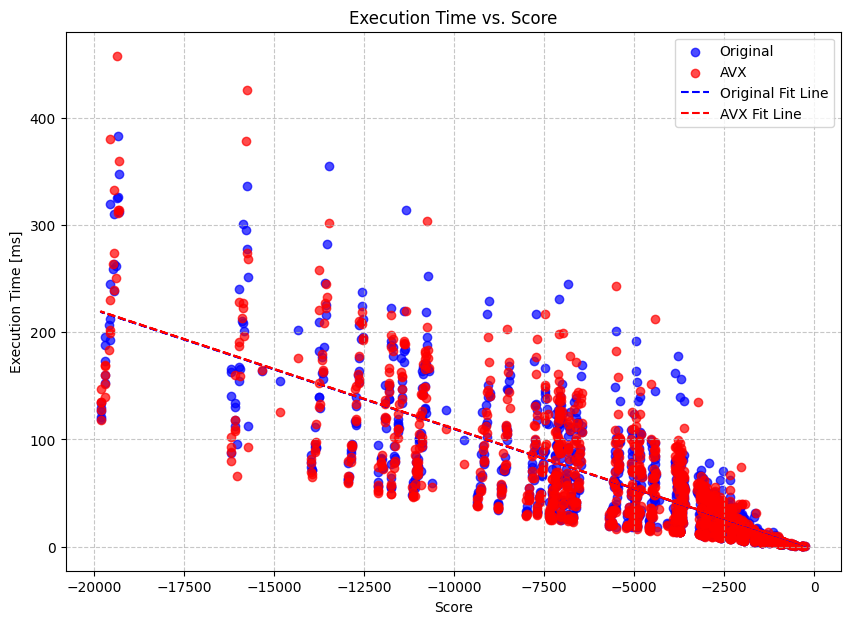

Processing B...


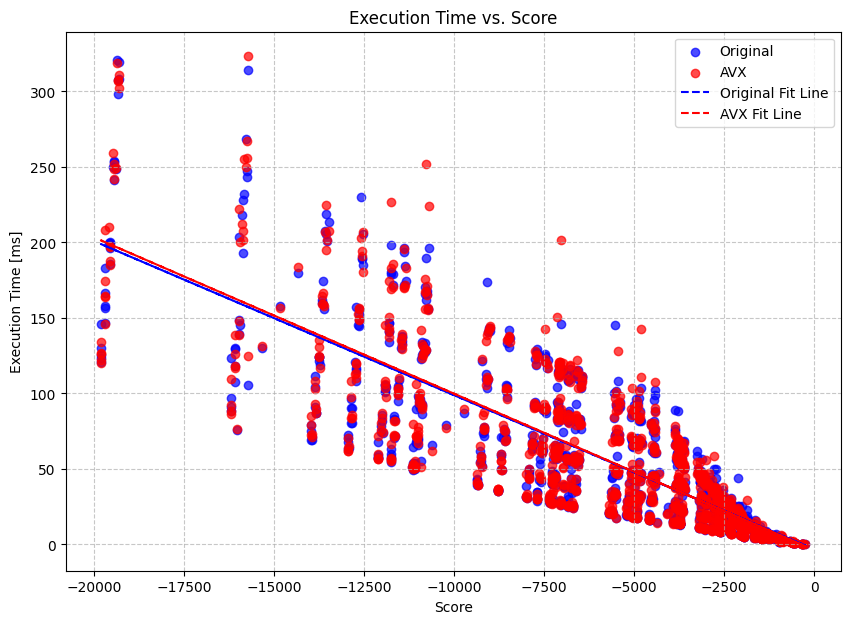

Processing BE...


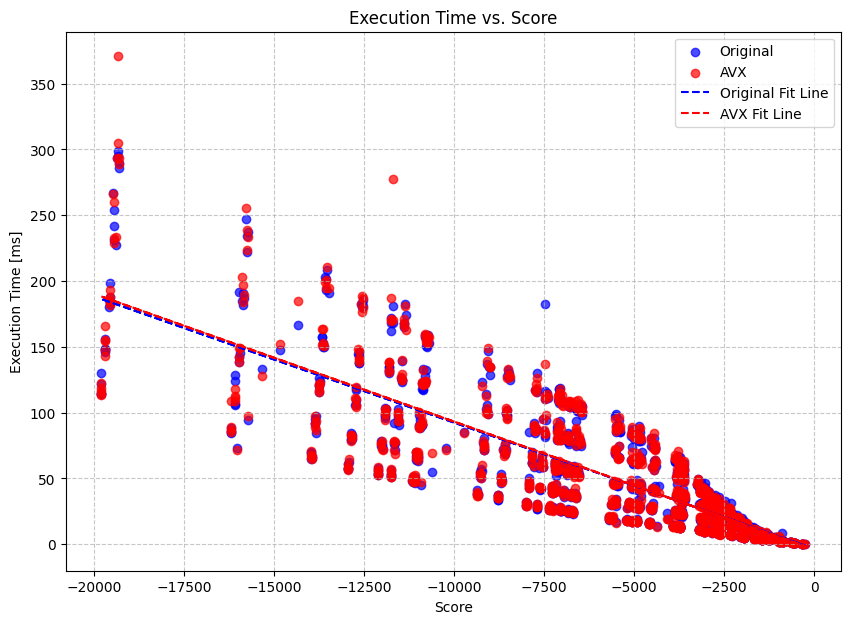

Processing BN...


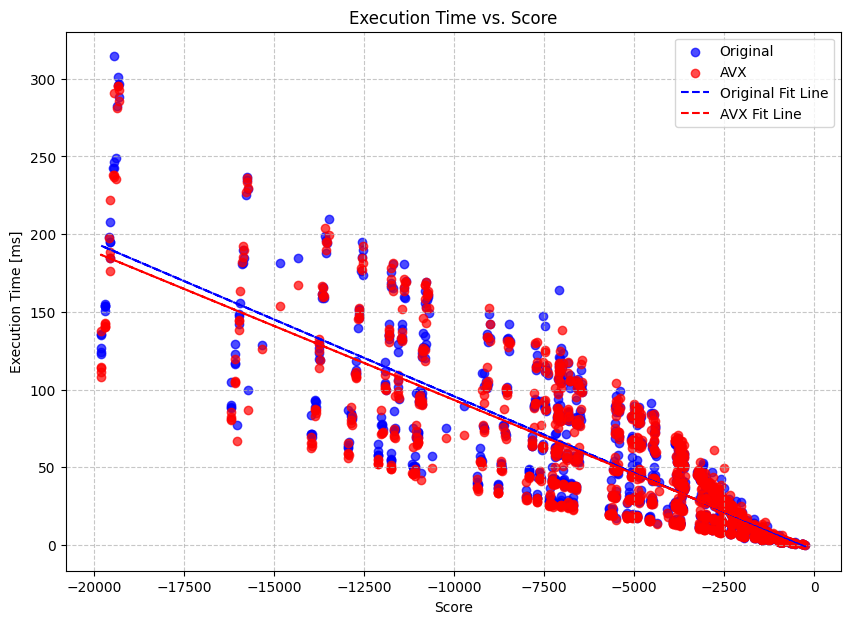

Processing E...


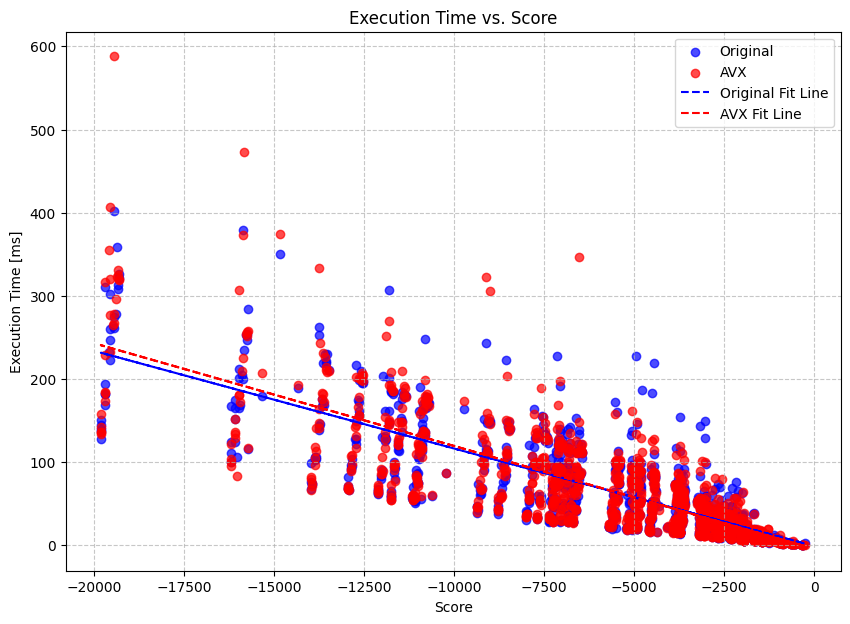

Processing EN...


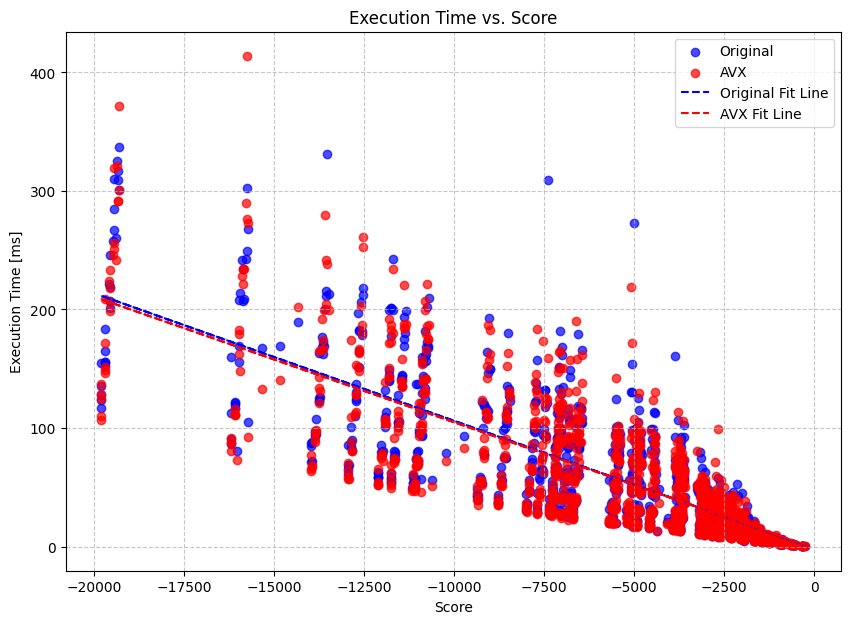

Processing N...


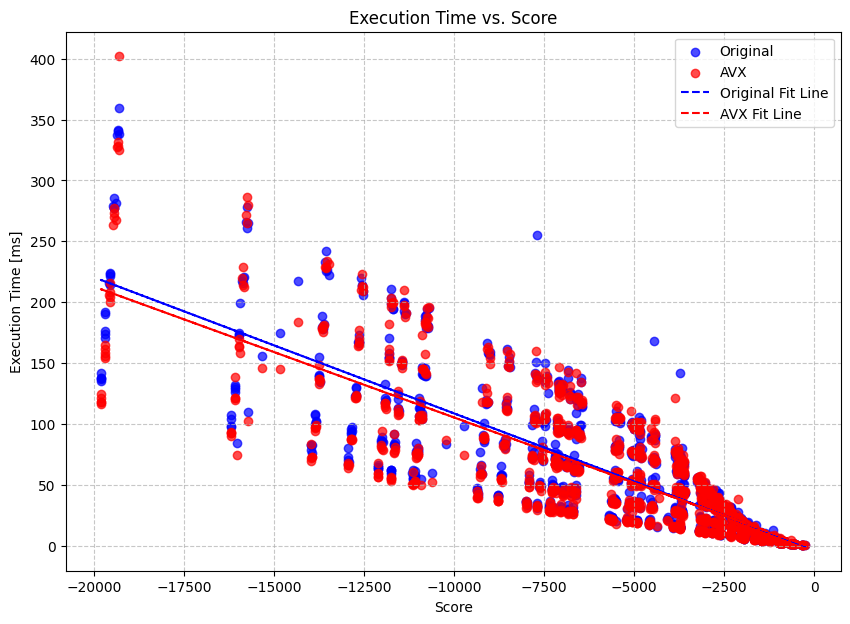

Processing O...


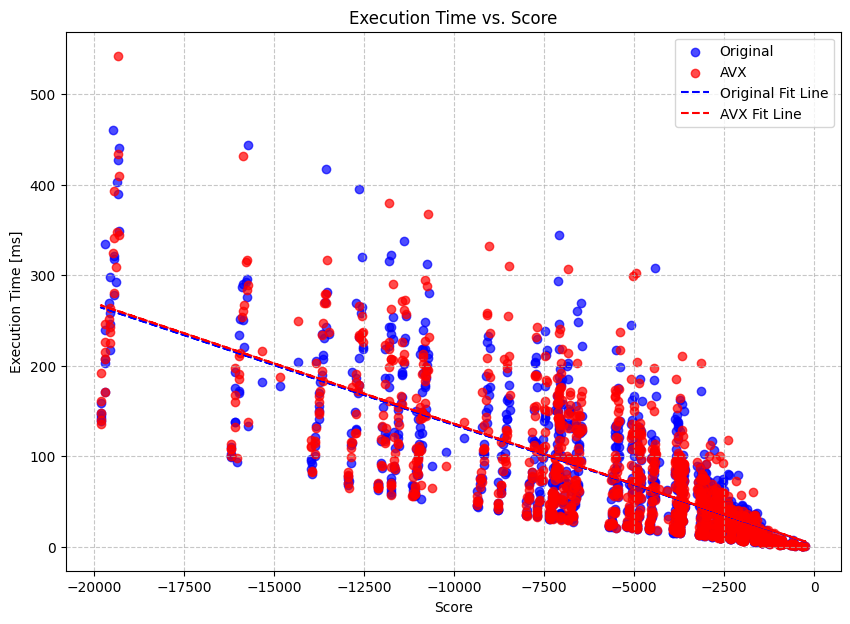

Processing OB...


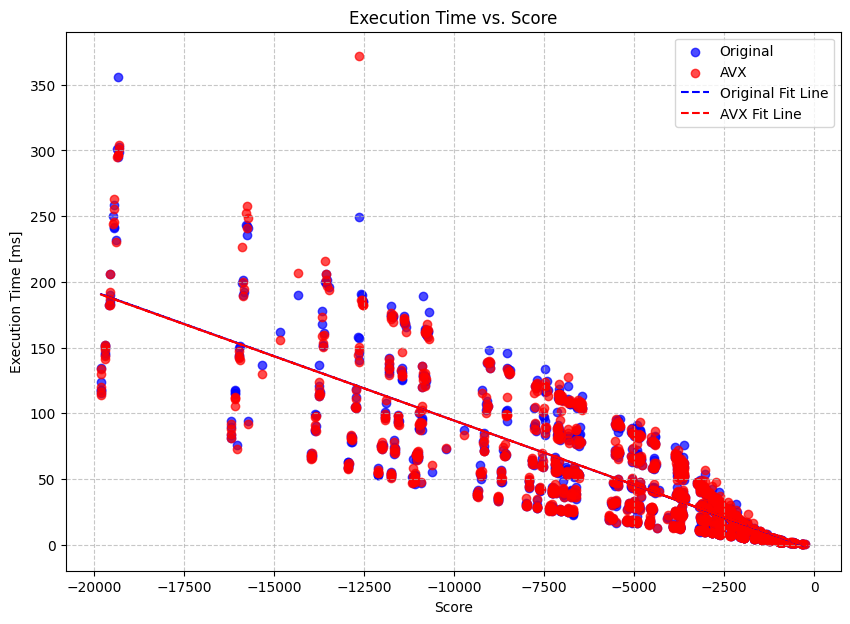

Processing OE...


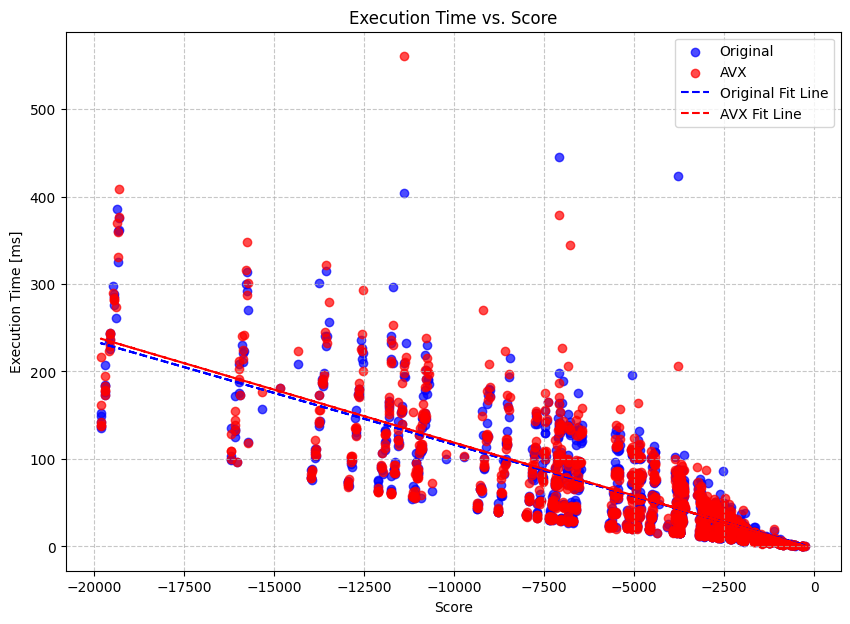

Processing ON...


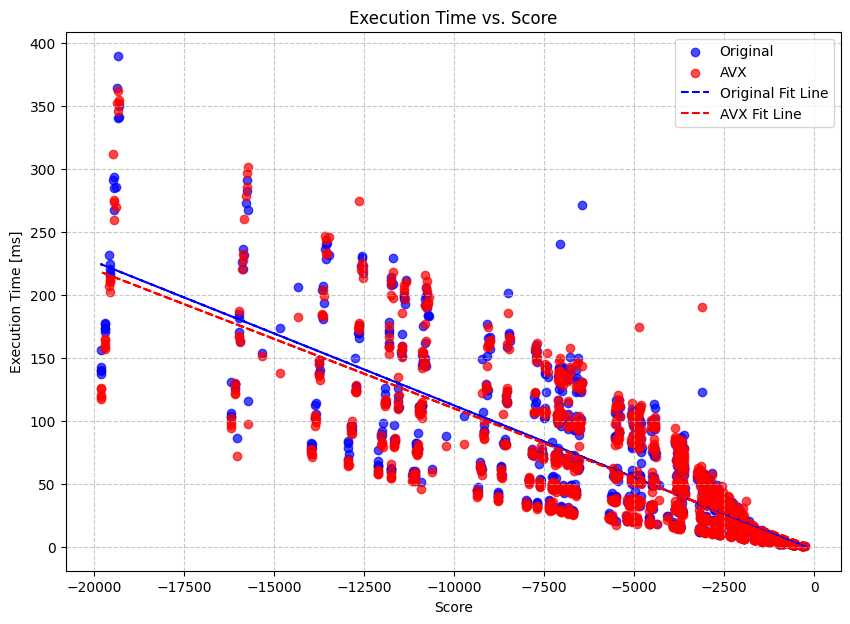

In [5]:
for name, analyzer in performance_analyzers.items():
    print(f"Processing {name}...")
    analyzer.extract_data()
    analyzer.compute_metrics()
    analyzer.plot_execution_time_vs_score()

Processing E with AVX slope: -0.0124, Original slope: -0.0117, Difference: -0.0006


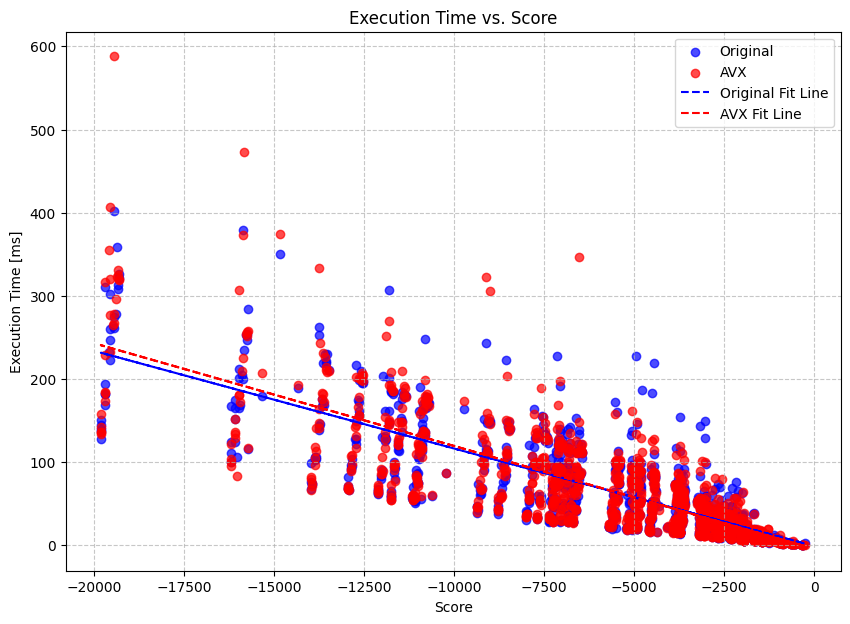

Processing OE with AVX slope: -0.0121, Original slope: -0.0118, Difference: -0.0003


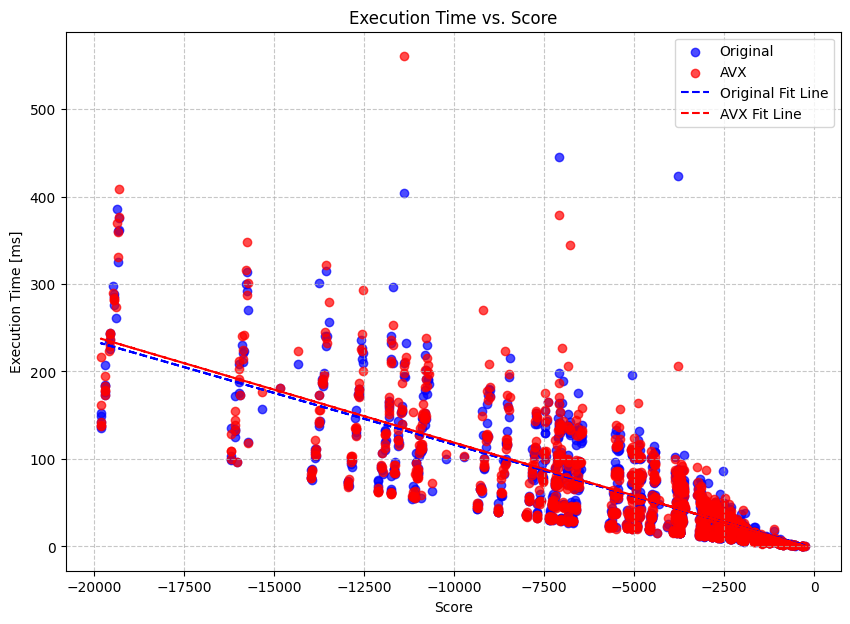

Processing B with AVX slope: -0.0104, Original slope: -0.0102, Difference: -0.0001


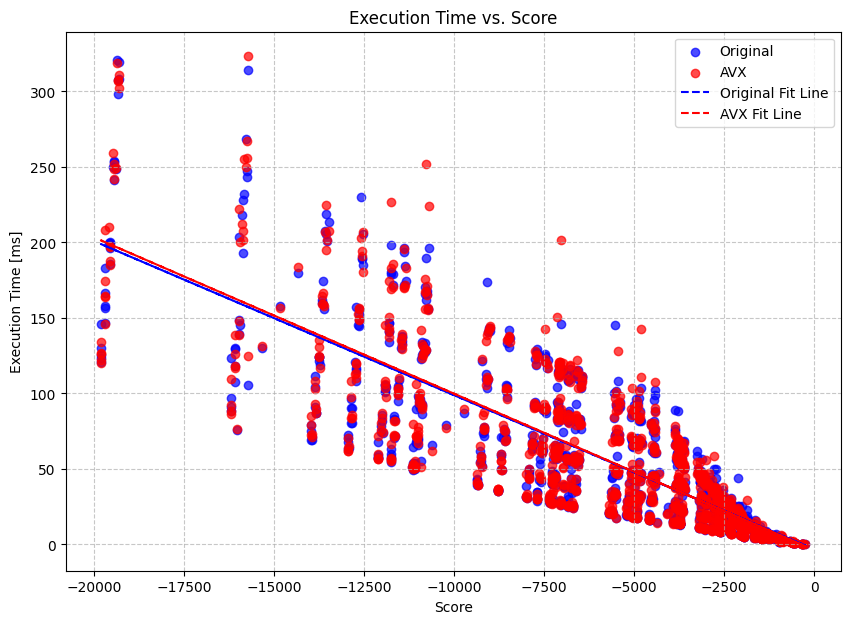

Processing BE with AVX slope: -0.0097, Original slope: -0.0096, Difference: -0.0001


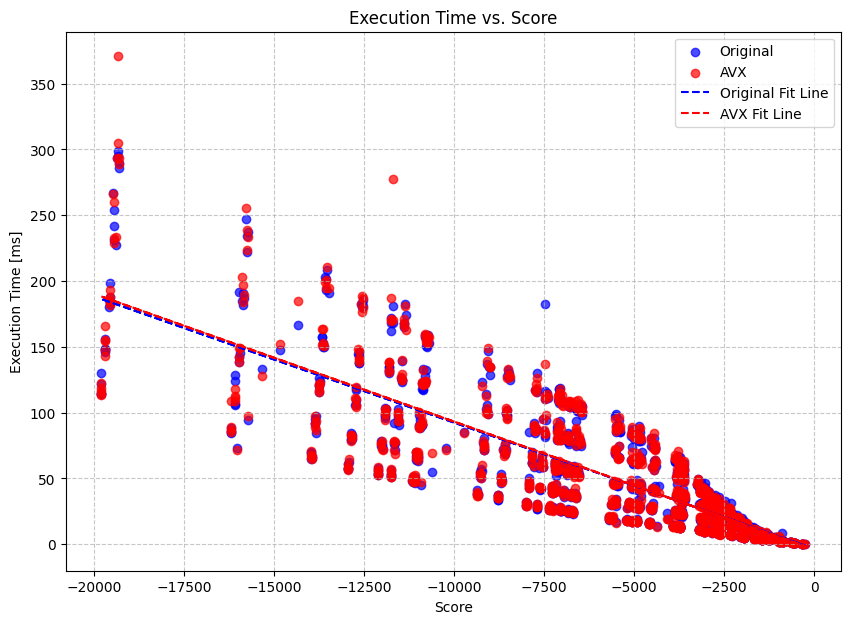

Processing O with AVX slope: -0.0134, Original slope: -0.0133, Difference: -0.0001


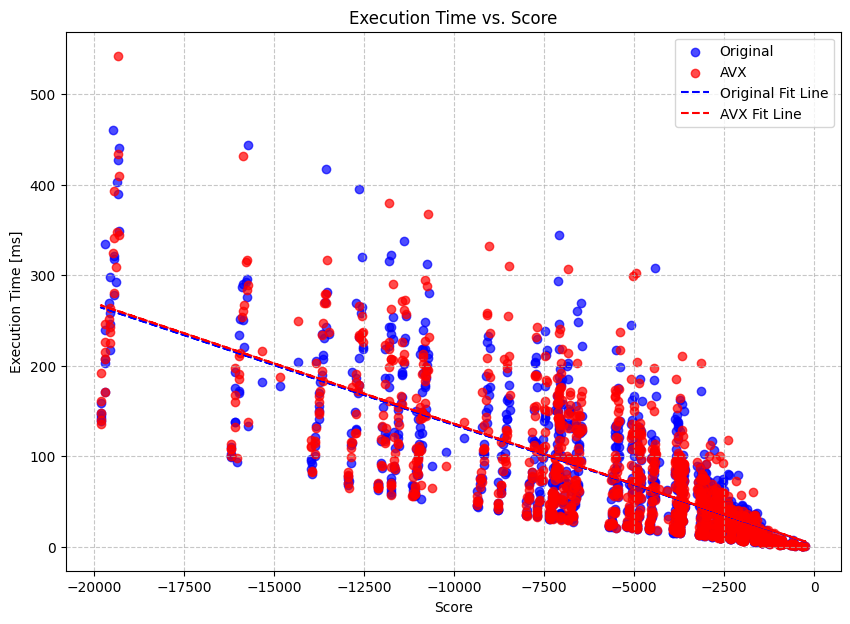

Processing complete with AVX slope: -0.0112, Original slope: -0.0111, Difference: -0.0000


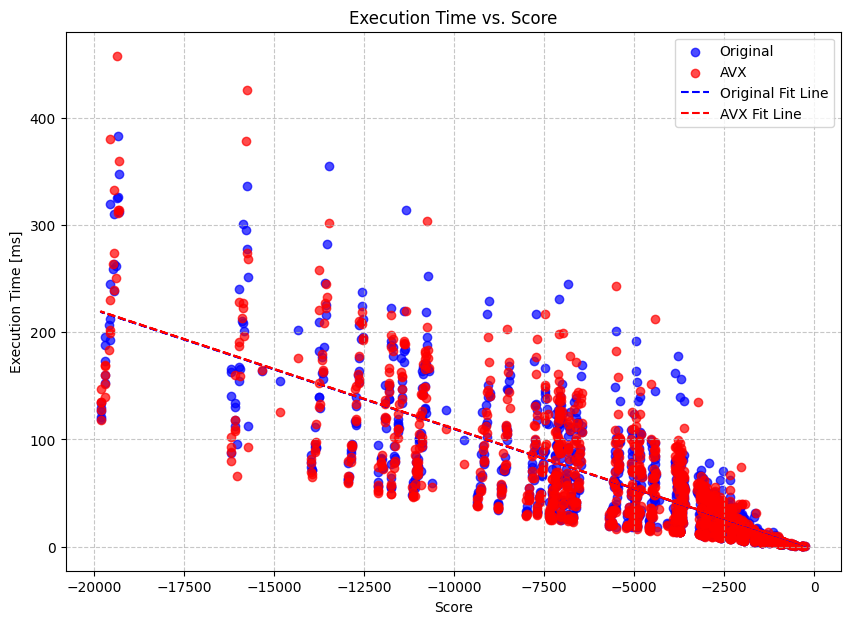

Processing OB with AVX slope: -0.0098, Original slope: -0.0098, Difference: 0.0000


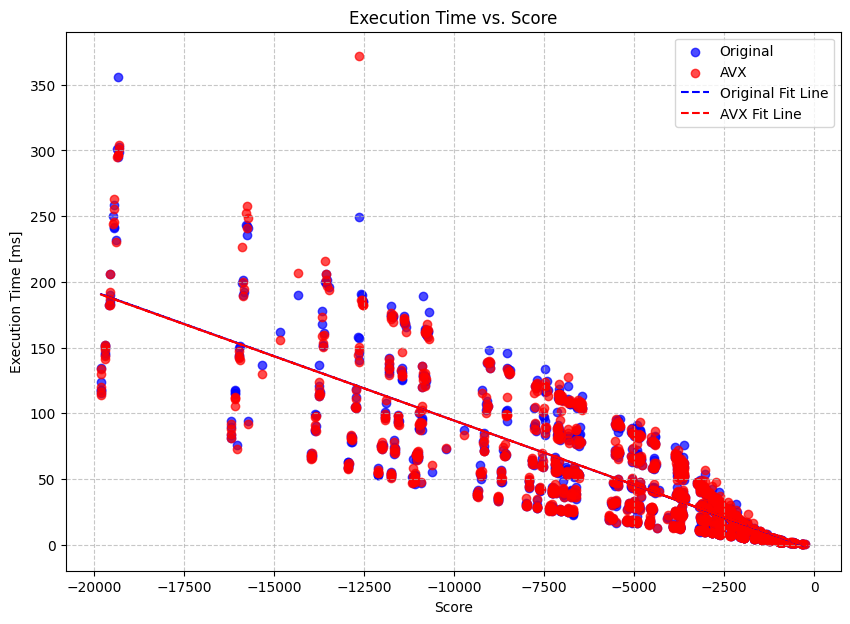

Processing EN with AVX slope: -0.0106, Original slope: -0.0108, Difference: 0.0002


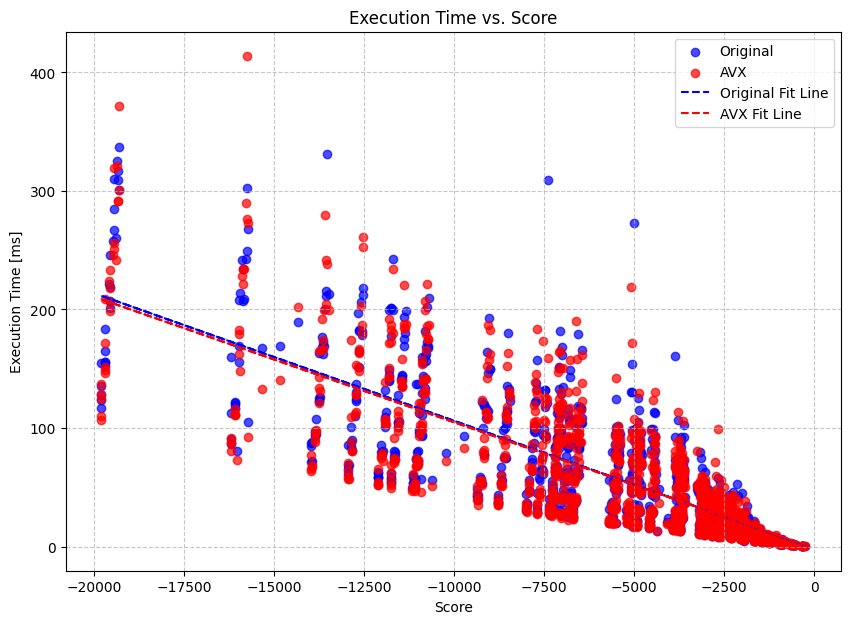

Processing BN with AVX slope: -0.0095, Original slope: -0.0099, Difference: 0.0004


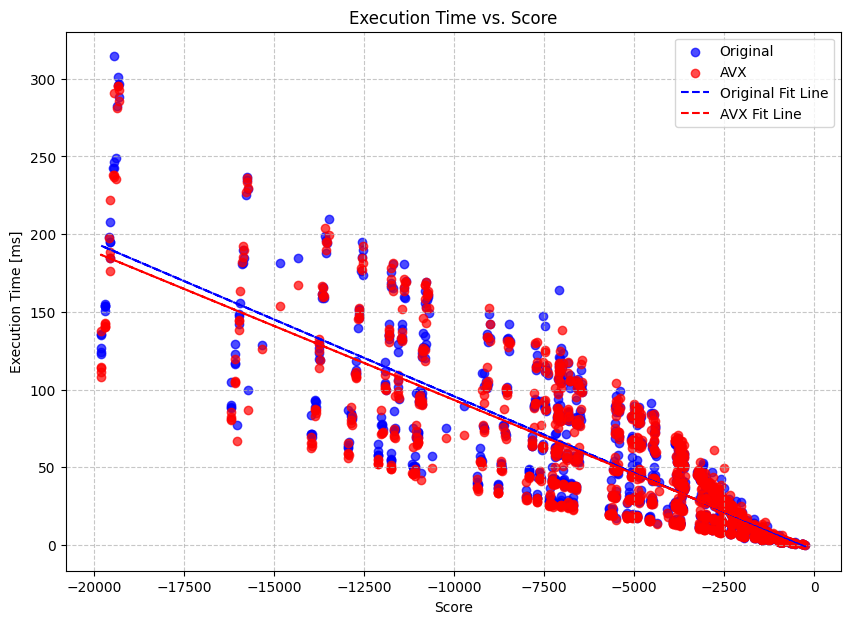

Processing ON with AVX slope: -0.0110, Original slope: -0.0114, Difference: 0.0004


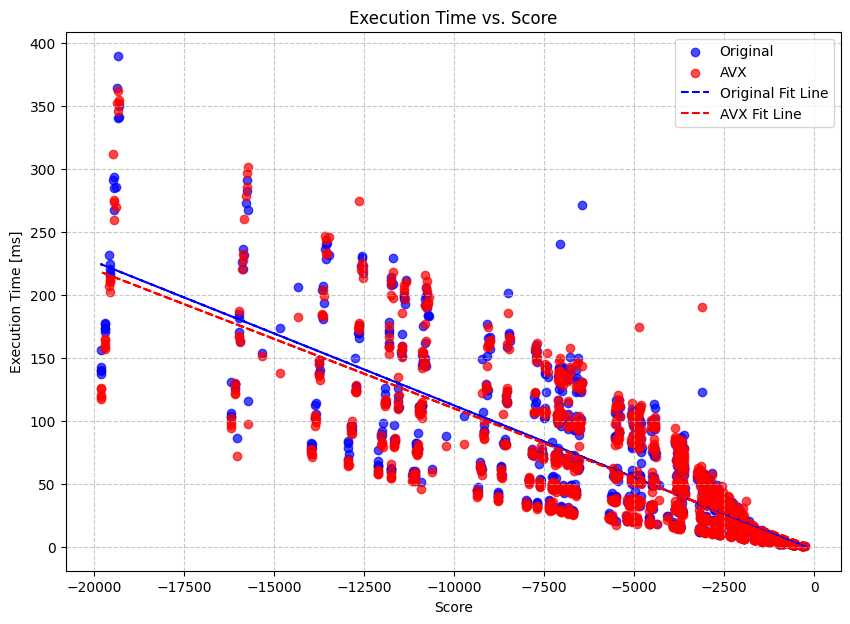

Processing N with AVX slope: -0.0107, Original slope: -0.0112, Difference: 0.0004


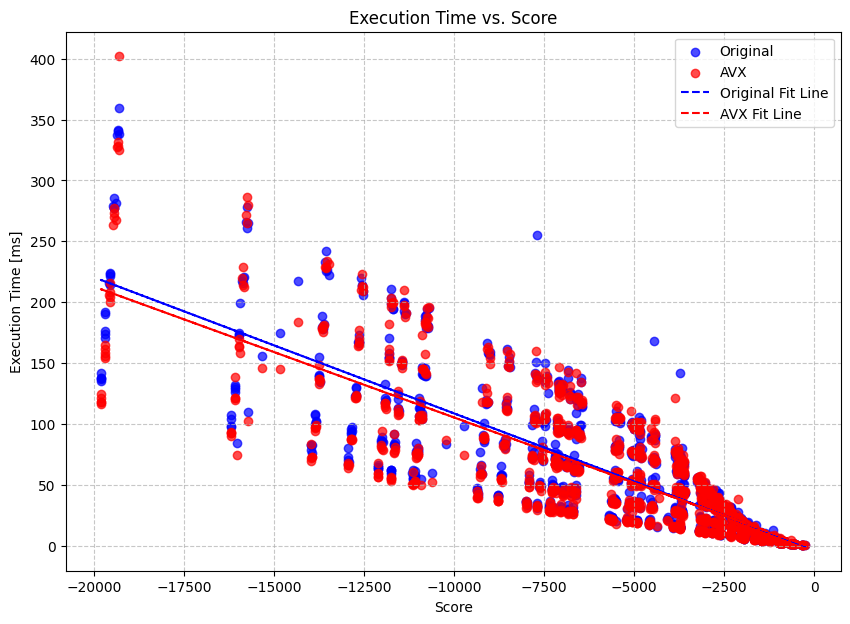

In [6]:
# Calculate the slope for both original times and AVX times, and sort by the difference in slopes (AVX slope - Original slope)
sorted_analyzers = sorted(performance_analyzers.items(), 
                          key=lambda item: np.polyfit(item[1].scores, item[1].avx_times, 1)[0] - np.polyfit(item[1].scores, item[1].original_times, 1)[0], 
                          reverse=False)

# Now process the analyzers in the sorted order
for name, analyzer in sorted_analyzers:
    slope_avx = np.polyfit(analyzer.scores, analyzer.avx_times, 1)[0]
    slope_original = np.polyfit(analyzer.scores, analyzer.original_times, 1)[0]
    slope_diff = slope_avx - slope_original
    print(f"Processing {name} with AVX slope: {slope_avx:.4f}, Original slope: {slope_original:.4f}, Difference: {slope_diff:.4f}")
    analyzer.plot_execution_time_vs_score()